In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# Parameters
batch_size = 32
img_size = (224, 224)
data_dir = "C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_rice"

# Load dataset (tanpa split dulu)
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=None,  # Load as tf.data.Dataset of single samples
    shuffle=True
)

# Convert to list
full_dataset = list(full_dataset)
images = [x[0].numpy() for x in full_dataset]
labels = [x[1].numpy() for x in full_dataset]

Found 5932 files belonging to 4 classes.


In [3]:
# Split ke train/val/test: 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Convert ke tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Normalisasi
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Dapatkan jumlah kelas
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_size + (3,)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [6]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Training
model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
112/112 [==============================] - 449s 4s/step - loss: 1.0604 - accuracy: 0.5736 - val_loss: 0.6599 - val_accuracy: 0.7692
Epoch 2/20
112/112 [==============================] - 406s 4s/step - loss: 0.6752 - accuracy: 0.7501 - val_loss: 0.4335 - val_accuracy: 0.8349
Epoch 3/20
112/112 [==============================] - 379s 3s/step - loss: 0.4393 - accuracy: 0.8392 - val_loss: 0.3421 - val_accuracy: 0.8922
Epoch 4/20
112/112 [==============================] - 416s 4s/step - loss: 0.2849 - accuracy: 0.8991 - val_loss: 0.2556 - val_accuracy: 0.9242
Epoch 5/20
112/112 [==============================] - 400s 4s/step - loss: 0.2277 - accuracy: 0.9165 - val_loss: 0.3513 - val_accuracy: 0.8863
Epoch 6/20
112/112 [==============================] - 390s 3s/step - loss: 0.1595 - accuracy: 0.9415 - val_loss: 0.1790 - val_accuracy: 0.9511
Epoch 7/20
112/112 [==============================] - 399s 4s/step - loss: 0.1447 - accuracy: 0.9511 - val_loss: 0.1881 - val_accuracy: 0.9503

In [8]:
# Evaluasi
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")

38/38 [==============================] - 19s 462ms/step - loss: 0.1809 - accuracy: 0.9764
Test Accuracy: 97.64%


In [9]:
# ==== SAVE MODEL ====
model.save('C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/models/predict_disease_model_rice.h5')

In [12]:
# Ambil label sebenarnya
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Lakukan prediksi
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

38/38 [==============================] - 39s 992ms/step


                 precision    recall  f1-score   support

Bacterialblight       0.96      0.97      0.96       317
          Blast       0.99      0.98      0.98       288
      Brownspot       0.98      0.99      0.98       320
         Tungro       0.98      0.98      0.98       262

       accuracy                           0.98      1187
      macro avg       0.98      0.98      0.98      1187
   weighted avg       0.98      0.98      0.98      1187



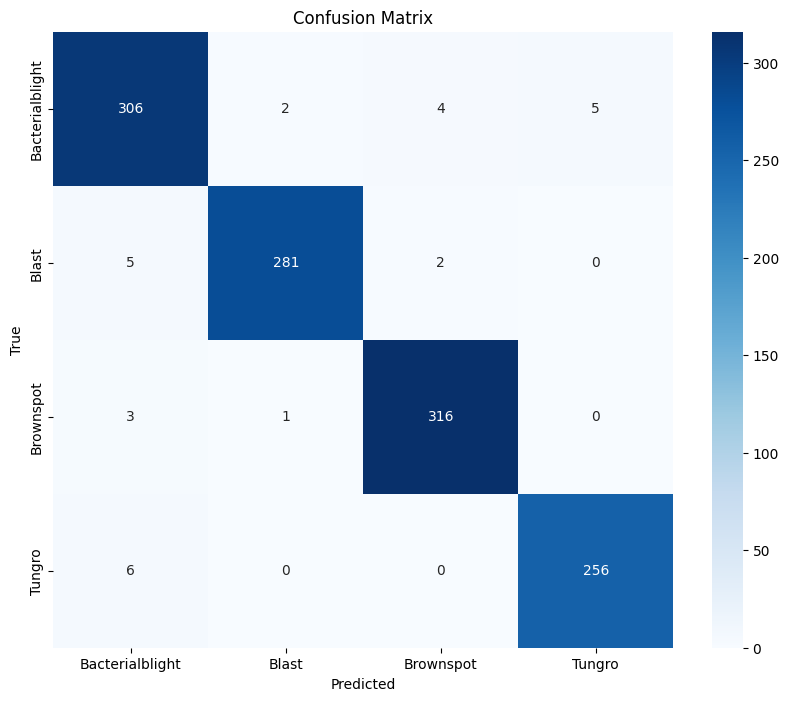

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()